# Optimizing CNNs for Handwritten Character Recognition on EMNIST with W&B Hyperparameter Sweeps

**Abstract:**  
This notebook demonstrates a complete deep learning workflow for classifying handwritten characters using the EMNIST Balanced dataset. We define a configurable CNN in PyTorch, train a baseline model, perform automated hyperparameter optimization with W&B, and compare results using accuracy, loss curves, and confusion matrices.

In [1]:
# Imports
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms
from torchvision.datasets import EMNIST
from torch.utils.data import DataLoader, random_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np
from tqdm import trange
import matplotlib.pyplot as plt
import wandb

# Device selection
device = "cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu"
print(f"Using {device} device")

Using cuda device


## Data Preparation

We use the EMNIST Balanced dataset (digits + letters).  
Steps:
- Convert images to tensors and normalize to [-1, 1]
- Split training set into train (80%) and validation (20%)
- Test set remains separate for evaluation


In [2]:
# Transform pipeline
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Load EMNIST dataset
train_dataset = EMNIST(root='./data', split='balanced', train=True, download=True, transform=transform)
test_dataset = EMNIST(root='./data', split='balanced', train=False, download=True, transform=transform)

# Train / validation split
train_size = int(0.8 * len(train_dataset))
val_size = len(train_dataset) - train_size
train_subset, val_subset = random_split(train_dataset, [train_size, val_size])

# Class labels
classes = train_dataset.classes
print(f"Classes: {classes}")


100%|██████████| 562M/562M [00:04<00:00, 120MB/s]


Classes: ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', 'a', 'b', 'd', 'e', 'f', 'g', 'h', 'n', 'q', 'r', 't']


## Visualization Utilities

- `show_samples()`: visualizes n sample images with their labels
- `plot_confusion_matrix()`: visualizes model predictions across classes


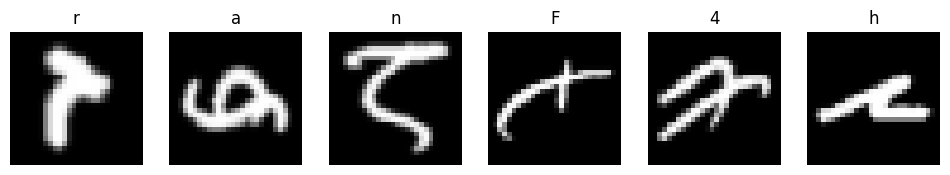

In [3]:
def show_samples(dataset, classes, n=6):
    fig, axes = plt.subplots(1, n, figsize=(12, 3))
    for i in range(n):
        img, label = dataset[i]
        axes[i].imshow(img.squeeze(), cmap="gray")
        axes[i].set_title(classes[label])
        axes[i].axis("off")
    plt.show()

show_samples(train_dataset, classes)


## CNN Model

Customizable CNN:
- Conv blocks: Conv2d → ReLU → MaxPool2d
- Automatic shape inference for fully connected layers
- FC layers: Linear → ReLU → Dropout → Linear (num_classes)
- Hyperparameters: num_filters, kernel_size, num_layers, dropout


In [4]:
class CNN(nn.Module):
    def __init__(self, num_classes=len(classes), num_filters=32, kernel_size=3, num_layers=2, dropout=0.5):
        super(CNN, self).__init__()
        layers = []
        in_channels = 1
        for i in range(num_layers):
            layers.append(nn.Conv2d(in_channels, num_filters, kernel_size=kernel_size, padding=1))
            layers.append(nn.ReLU())
            layers.append(nn.MaxPool2d(2, 2))
            in_channels = num_filters
        self.conv = nn.Sequential(*layers)

        # Automatic flattened size
        with torch.no_grad():
            dummy_input = torch.zeros(1, 1, 28, 28)
            conv_out = self.conv(dummy_input)
            conv_out_size = conv_out.numel()

        self.fc1 = nn.Linear(conv_out_size, 128)
        self.dropout = nn.Dropout(dropout)
        self.fc2 = nn.Linear(128, num_classes)

    def forward(self, x):
        x = self.conv(x)
        x = x.view(x.size(0), -1)
        x = torch.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x


## Training & Evaluation Utilities

- `train_step()`: trains one epoch
- `test_step()`: evaluates model
- Returns loss and accuracy (%)


In [5]:
def train_step(model, criterion, optimizer, dataloader, device=device):
    running_loss, correct = 0, 0
    model.train()
    for x, y in dataloader:
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad()
        pred = model(x)
        loss = criterion(pred, y)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    return running_loss / len(dataloader), 100 * correct / len(dataloader.dataset)

def test_step(model, criterion, dataloader, device=device):
    running_loss, correct = 0, 0
    model.eval()
    with torch.no_grad():
        for x, y in dataloader:
            x, y = x.to(device), y.to(device)
            pred = model(x)
            running_loss += criterion(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    return running_loss / len(dataloader), 100 * correct / len(dataloader.dataset)

def plot_confusion_matrix(model, dataloader, title="Confusion Matrix"):
    y_true, y_pred = [], []
    model.eval()
    with torch.no_grad():
        for x, y in dataloader:
            x, y = x.to(device), y.to(device)
            preds = model(x)
            y_true.extend(y.cpu().numpy())
            y_pred.extend(preds.argmax(1).cpu().numpy())
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
    disp.plot(cmap=plt.cm.Blues, xticks_rotation="vertical")
    plt.title(title)
    plt.show()


## Baseline CNN Training

- Model: 2 conv layers, 32 filters, kernel_size=3, dropout=0.5
- Optimizer: Adam, lr=0.001
- Train for 5 epochs
- Batch size: 64


In [ ]:
baseline_model = CNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(baseline_model.parameters(), lr=0.001)

train_loader = DataLoader(train_subset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_subset, batch_size=64, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

baseline_train_losses, baseline_val_losses = [], []
baseline_train_accs, baseline_val_accs = [], []

for epoch in range(5):
    train_loss, train_acc = train_step(baseline_model, criterion, optimizer, train_loader)
    val_loss, val_acc = test_step(baseline_model, criterion, val_loader)
    baseline_train_losses.append(train_loss)
    baseline_val_losses.append(val_loss)
    baseline_train_accs.append(train_acc)
    baseline_val_accs.append(val_acc)
    print(f"[Baseline] Epoch {epoch+1}: Train Acc={train_acc:.2f}%, Val Acc={val_acc:.2f}%")

baseline_test_loss, baseline_test_acc = test_step(baseline_model, criterion, test_loader)
print(f"Baseline Test Accuracy: {baseline_test_acc:.2f}%")
plot_confusion_matrix(baseline_model, test_loader, title="Baseline Confusion Matrix")


[Baseline] Epoch 1: Train Acc=61.19%, Val Acc=81.87%
[Baseline] Epoch 2: Train Acc=74.77%, Val Acc=84.09%
[Baseline] Epoch 3: Train Acc=77.39%, Val Acc=84.69%
[Baseline] Epoch 4: Train Acc=78.87%, Val Acc=85.63%
[Baseline] Epoch 5: Train Acc=80.04%, Val Acc=85.82%
